# Your First Convolutional Neural Network

This notebook implements a CNN on the CIFAR-10 dataset with BatchNormalization,
LeakyReLU activations, and Dropout for regularization.

**Standards Applied:**
- ✅ GPU memory growth enabled
- ✅ Global configuration block with dynamic batch/epoch scaling
- ✅ W&B integration for experiment tracking
- ✅ LRFinder for optimal learning rate detection
- ✅ Full callback stack (WandbMetricsLogger, LRScheduler, EarlyStopping, LRLogger)
- ✅ Enhanced training visualizations
- ✅ Kernel restart cell (commented out)

## GPU Setup

In [1]:
# ═══════════════════════════════════════════════════════════════════════════════
# GPU MEMORY GROWTH
# Enable memory growth to prevent TensorFlow from allocating all GPU memory
# ═══════════════════════════════════════════════════════════════════════════════
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    print(f"GPU(s) available: {[gpu.name for gpu in gpus]}")
else:
    print("WARNING: No GPU detected, running on CPU")

2026-01-03 16:55:41.486432: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/cataluna84/Workspace-Antigravity/Generative_Deep_Learning/.venv/lib/python3.13/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


GPU(s) available: ['/physical_device:GPU:0']


## Imports

In [2]:
# Standard library imports
import numpy as np
import matplotlib.pyplot as plt

# TensorFlow/Keras imports
from keras.layers import (
    Input, Flatten, Dense, Conv2D,
    BatchNormalization, LeakyReLU, Dropout, Activation
)
from keras.models import Model
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.datasets import cifar10

# Path setup for project utilities
import sys
sys.path.insert(0, '../..')    # For project root utils/

# Project utilities
from utils.wandb_utils import init_wandb, get_metrics_logger
from utils.callbacks import LRFinder, get_lr_scheduler, get_early_stopping, LRLogger
from utils.gpu_utils import (
    get_optimal_batch_size,
    calculate_adjusted_epochs,
    get_gpu_vram_gb,
    print_training_config
)

# W&B
import wandb
from wandb.integration.keras import WandbMetricsLogger

## Global Configuration

In [ ]:
# ═══════════════════════════════════════════════════════════════════════════════
# GLOBAL CONFIGURATION
# All hyperparameters and settings are defined here for easy modification
# ═══════════════════════════════════════════════════════════════════════════════

# Reference values (original notebook settings for epoch scaling)
REFERENCE_BATCH_SIZE = 32   # Original book value
REFERENCE_EPOCHS = 200      # Original book value

# Auto-detect GPU VRAM or override manually
TARGET_VRAM_GB = None  # Set to 6, 8, 12, etc. to override detection
GPU_VRAM_GB = TARGET_VRAM_GB if TARGET_VRAM_GB else get_gpu_vram_gb()

# Calculate optimal settings dynamically based on GPU VRAM
# Uses 'cifar10' profile for CIFAR-10 classification networks
BATCH_SIZE = get_optimal_batch_size('cifar10', vram_gb=GPU_VRAM_GB)
EPOCHS = calculate_adjusted_epochs(REFERENCE_EPOCHS, REFERENCE_BATCH_SIZE, BATCH_SIZE)

# Ensure minimum epochs for meaningful training
EPOCHS = max(EPOCHS, 10)

# Learning rate (will be set by LRFinder)
LEARNING_RATE = "auto"

# Model configuration
NUM_CLASSES = 10
CONV_FILTERS = [32, 32, 64, 64]  # Filters for each conv layer
DENSE_UNITS = 128                 # Dense layer size
DROPOUT_RATE = 0.5

# W&B configuration
MODEL_TYPE = "cnn"
DATASET_NAME = "cifar10"
OPTIMIZER_NAME = "adam"
LAYERS_DESC = "4_conv_2_dense"

# Print configuration summary
print_training_config(
    MODEL_TYPE, BATCH_SIZE, EPOCHS,
    REFERENCE_BATCH_SIZE, REFERENCE_EPOCHS, GPU_VRAM_GB
)

════════════════════════════════════════════════════════════════════
TRAINING CONFIGURATION
════════════════════════════════════════════════════════════════════
Model Type:     CNN
GPU VRAM:       8 GB
Batch Size:     2048 (reference: 32)
Epochs:         100 (reference: 10)
Scale Factor:   10.00x epochs
════════════════════════════════════════════════════════════════════


I0000 00:00:1767459349.711977    1594 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6094 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2070, pci bus id: 0000:01:00.0, compute capability: 7.5


## Load and Preprocess Data

In [4]:
# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Normalize pixel values to [0, 1]
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# One-hot encode labels
y_train = to_categorical(y_train, NUM_CLASSES)
y_test = to_categorical(y_test, NUM_CLASSES)

print(f"Training samples: {x_train.shape[0]}")
print(f"Test samples: {x_test.shape[0]}")
print(f"Image shape: {x_train.shape[1:]}")

/home/cataluna84/Workspace-Antigravity/Generative_Deep_Learning/.venv/lib/python3.13/site-packages/keras/src/datasets/cifar.py:18: VisibleDeprecationWarning: dtype(): align should be passed as Python or NumPy boolean but got `align=0`. Did you mean to pass a tuple to create a subarray type? (Deprecated NumPy 2.4)
  d = cPickle.load(f, encoding="bytes")


Training samples: 50000
Test samples: 10000
Image shape: (32, 32, 3)


## W&B Initialization

In [5]:
# Initialize W&B for experiment tracking
run = init_wandb(
    name="02_03_cnn",
    config={
        "model": MODEL_TYPE,
        "dataset": DATASET_NAME,
        "layers": LAYERS_DESC,
        "conv_filters": CONV_FILTERS,
        "dense_units": DENSE_UNITS,
        "dropout_rate": DROPOUT_RATE,
        "learning_rate": LEARNING_RATE,  # Will be updated after LRFinder
        "batch_size": BATCH_SIZE,
        "epochs": EPOCHS,
        "optimizer": OPTIMIZER_NAME,
        "gpu_vram_gb": GPU_VRAM_GB,
    }
)

wandb: Currently logged in as: cataluna84 to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


## Model Architecture

CNN with 4 convolutional layers, BatchNormalization, LeakyReLU, and Dropout.

In [6]:
# Build the CNN model using Keras Functional API
input_layer = Input((32, 32, 3))

# Conv Block 1: 32 filters, stride 1
x = Conv2D(filters=CONV_FILTERS[0], kernel_size=3, strides=1, padding='same')(input_layer)
x = BatchNormalization()(x)
x = LeakyReLU()(x)

# Conv Block 2: 32 filters, stride 2 (downsampling)
x = Conv2D(filters=CONV_FILTERS[1], kernel_size=3, strides=2, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)

# Conv Block 3: 64 filters, stride 1
x = Conv2D(filters=CONV_FILTERS[2], kernel_size=3, strides=1, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)

# Conv Block 4: 64 filters, stride 2 (downsampling)
x = Conv2D(filters=CONV_FILTERS[3], kernel_size=3, strides=2, padding='same')(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)

# Flatten and Dense layers
x = Flatten()(x)
x = Dense(DENSE_UNITS)(x)
x = BatchNormalization()(x)
x = LeakyReLU()(x)
x = Dropout(rate=DROPOUT_RATE)(x)

# Output layer
x = Dense(NUM_CLASSES)(x)
output_layer = Activation('softmax')(x)

model = Model(input_layer, output_layer)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 8, 8, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       524,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 10)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 592,554 (2.26 MB)

 Trainable params: 591,914 (2.26 MB)

 Non-trainable params: 640 (2.50 KB)

## Find Optimal Learning Rate

2026-01-03 16:56:18.107685: I external/local_xla/xla/service/service.cc:163] XLA service 0x7814f4115f20 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2026-01-03 16:56:18.107751: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 2070, Compute Capability 7.5
2026-01-03 16:56:18.691563: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2026-01-03 16:56:19.926972: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91701
2026-01-03 16:56:21.881950: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[2048,32,32,32]{3,2,1,0}, u8[0]{0}) custom-call(f32[2048,3,32,32]{3,2,1,0}, f32[32,3,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call

Optimal Learning Rate (Recommended): 0.000047


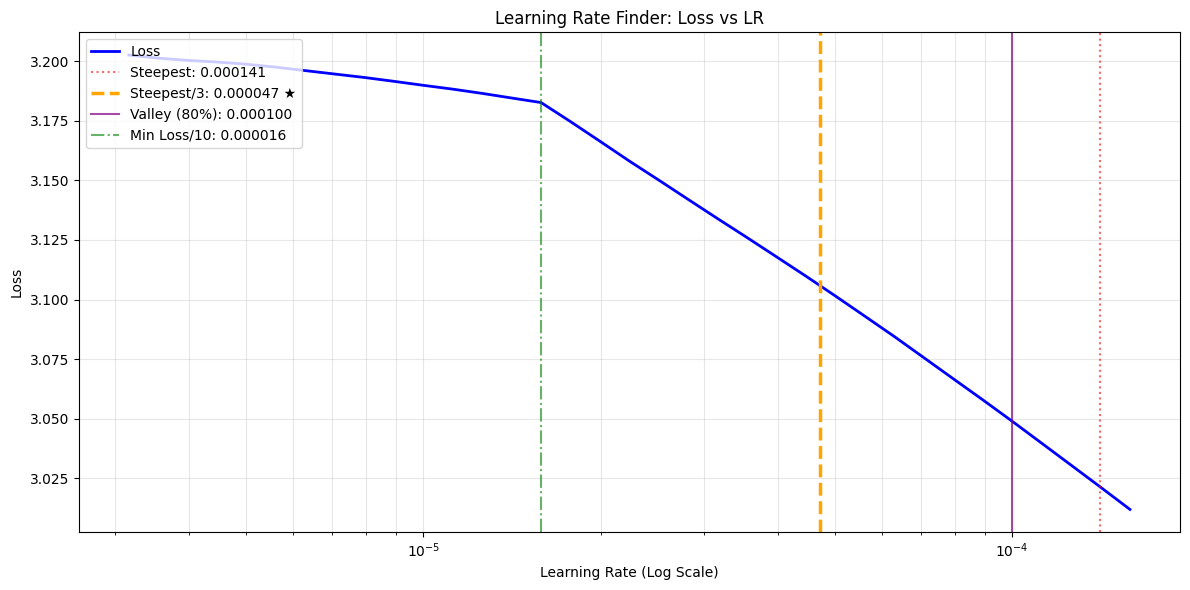

             LR FINDER RESULTS
  🔴 Steepest Gradient : 0.000141  (aggressive)
  🟠 Steepest / 3      : 0.000047  (balanced) ★ DEFAULT
  🟣 Valley (80%)      : 0.000100  (robust)
  🟢 Min Loss / 10     : 0.000016  (conservative)
  Selected Method: 'recommended' → LR = 0.000047

Optimal learning rate: 4.71e-05


In [7]:
# Clone model for LR finding (to avoid affecting the main model)
lr_model = tf.keras.models.clone_model(model)

# Compile with a very small initial learning rate
lr_model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=1e-6),
    metrics=['accuracy']
)

# Run LRFinder
lr_finder = LRFinder(min_lr=1e-6, max_lr=1e-1, steps=100)
lr_model.fit(
    x_train, y_train,
    batch_size=BATCH_SIZE,
    epochs=2,
    callbacks=[lr_finder],
    verbose=0
)

# Visualize and get optimal LR
lr_finder.plot_loss()
LEARNING_RATE = lr_finder.get_optimal_lr()

# Update W&B config with optimal learning rate
wandb.config.update({"learning_rate": LEARNING_RATE})
print(f"\nOptimal learning rate: {LEARNING_RATE:.2e}")

## Train Model

In [8]:
# Compile model with optimal learning rate
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=LEARNING_RATE),
    metrics=['accuracy']
)

# Define full callback stack
callbacks = [
    WandbMetricsLogger(),                              # W&B logging
    get_lr_scheduler(monitor='val_loss', patience=2),  # Reduce LR on plateau
    get_early_stopping(monitor='val_loss', patience=5),# Stop if no improvement
    LRLogger(),                                        # Log learning rate
]

# Train the model
history = model.fit(
    x_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    shuffle=True,
    validation_data=(x_test, y_test),
    callbacks=callbacks
)

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step - accuracy: 0.1493 - loss: 2.7778

2026-01-03 17:01:22.074513: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[1808,32,32,32]{3,2,1,0}, u8[0]{0}) custom-call(f32[1808,3,32,32]{3,2,1,0}, f32[32,3,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false,"reification_cost":[]}
2026-01-03 17:01:22.884412: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[1808,64,16,16]{3,2,1,0}, u8[0]{0}) custom-call(f32[1808,32,16,16]{3,2,1,0}, f32[64,32,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_targe

Epoch 1: Learning Rate is 4.71e-05
25/25 ━━━━━━━━━━━━━━━━━━━━ 30s 659ms/step - accuracy: 0.1836 - loss: 2.6013 - val_accuracy: 0.1051 - val_loss: 2.2816 - learning_rate: 4.7085e-05
Epoch 2/100
24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.2712 - loss: 2.2376Epoch 2: Learning Rate is 4.71e-05
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step - accuracy: 0.2828 - loss: 2.1815 - val_accuracy: 0.1610 - val_loss: 2.2766 - learning_rate: 4.7085e-05
Epoch 3/100
24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.3135 - loss: 2.0410Epoch 3: Learning Rate is 4.71e-05
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - accuracy: 0.3204 - loss: 2.0274 - val_accuracy: 0.1674 - val_loss: 2.2848 - learning_rate: 4.7085e-05
Epoch 4/100
24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.3389 - loss: 1.9549
Epoch 4: ReduceLROnPlateau reducing learning rate to 2.354229218326509e-05.
Epoch 4: Learning Rate is 2.35e-05
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - accuracy: 0.3461 - loss: 1.9256 - val_accuracy: 0

## Training Visualization

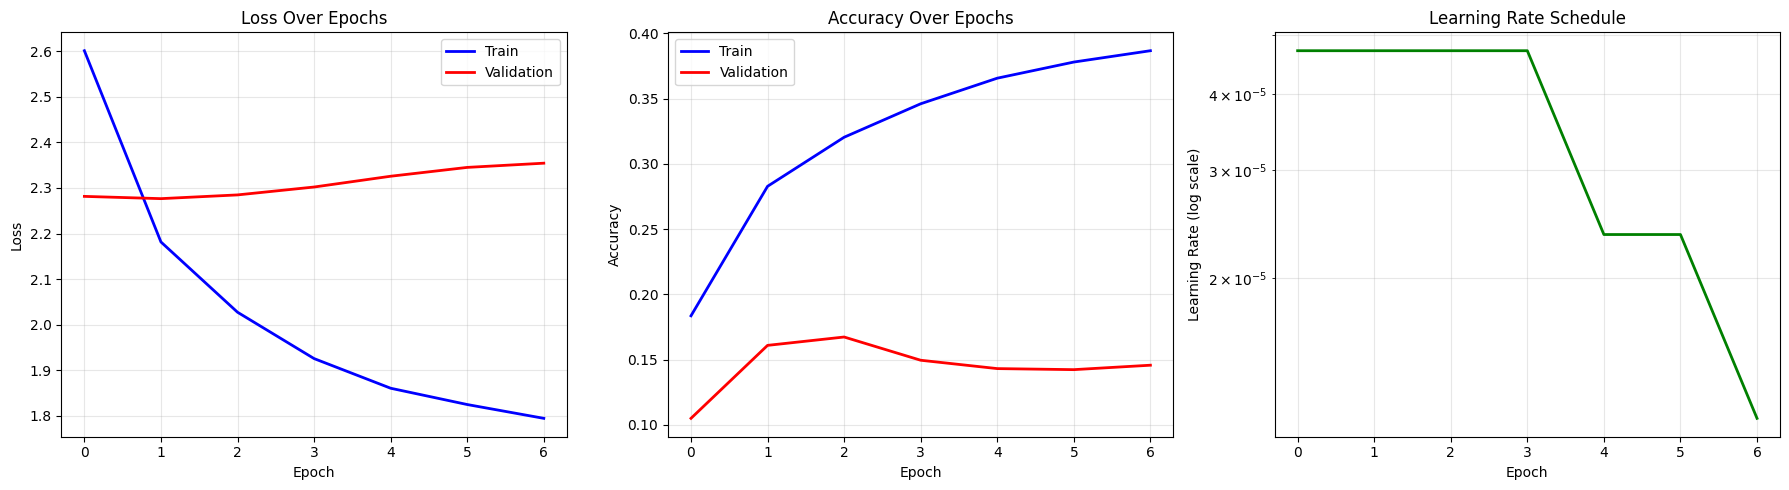


TRAINING SUMMARY
  Initial Loss    : 2.601280
  Final Loss      : 1.794443
  Min Loss        : 1.794443 (Epoch 7)
  Final Accuracy  : 0.3867
  Final Val Acc   : 0.1458
  Total Epochs    : 7
  Final LR        : 1.18e-05


In [9]:
# Plot training history
history_dict = history.history
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Training & Validation Loss
axes[0].plot(history_dict['loss'], 'b-', linewidth=2, label='Train')
axes[0].plot(history_dict['val_loss'], 'r-', linewidth=2, label='Validation')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Loss Over Epochs')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Training & Validation Accuracy
axes[1].plot(history_dict['accuracy'], 'b-', linewidth=2, label='Train')
axes[1].plot(history_dict['val_accuracy'], 'r-', linewidth=2, label='Validation')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Accuracy Over Epochs')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Plot 3: Learning Rate (LOG SCALE)
if 'learning_rate' in history_dict:
    axes[2].semilogy(history_dict['learning_rate'], 'g-', linewidth=2)
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('Learning Rate (log scale)')
    axes[2].set_title('Learning Rate Schedule')
    axes[2].grid(True, which='both', alpha=0.3)
else:
    axes[2].text(0.5, 0.5, 'LR not tracked', ha='center', va='center', fontsize=14)
    axes[2].set_title('Learning Rate (Not Available)')

plt.tight_layout()
plt.show()

# Print summary
print(f"\n{'='*60}")
print("TRAINING SUMMARY")
print(f"{'='*60}")
print(f"  Initial Loss    : {history_dict['loss'][0]:.6f}")
print(f"  Final Loss      : {history_dict['loss'][-1]:.6f}")
print(f"  Min Loss        : {min(history_dict['loss']):.6f} (Epoch {history_dict['loss'].index(min(history_dict['loss'])) + 1})")
print(f"  Final Accuracy  : {history_dict['accuracy'][-1]:.4f}")
print(f"  Final Val Acc   : {history_dict['val_accuracy'][-1]:.4f}")
print(f"  Total Epochs    : {len(history_dict['loss'])}")
if 'learning_rate' in history_dict:
    print(f"  Final LR        : {history_dict['learning_rate'][-1]:.2e}")
print(f"{'='*60}")

## Model Evaluation

In [10]:
# Evaluate on test set
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=1)
print(f"\nTest accuracy: {test_acc:.4f}")

2026-01-03 17:01:45.709621: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[32,32,32,32]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,3,32,32]{3,2,1,0}, f32[32,3,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false,"reification_cost":[]}
2026-01-03 17:01:46.006011: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[32,64,16,16]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,32,16,16]{3,2,1,0}, f32[64,32,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cud

311/313 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.1574 - loss: 2.2761

2026-01-03 17:01:51.473460: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[16,32,32,32]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,3,32,32]{3,2,1,0}, f32[32,3,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false,"reification_cost":[]}
2026-01-03 17:01:51.618019: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[16,64,16,16]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,32,16,16]{3,2,1,0}, f32[64,32,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cud

313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.1610 - loss: 2.2766

Test accuracy: 0.1610


## Analysis

In [11]:
# Class names for CIFAR-10
CLASSES = np.array(['airplane', 'automobile', 'bird', 'cat', 'deer',
                    'dog', 'frog', 'horse', 'ship', 'truck'])

# Make predictions
preds = model.predict(x_test)
preds_single = CLASSES[np.argmax(preds, axis=-1)]
actual_single = CLASSES[np.argmax(y_test, axis=-1)]

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step


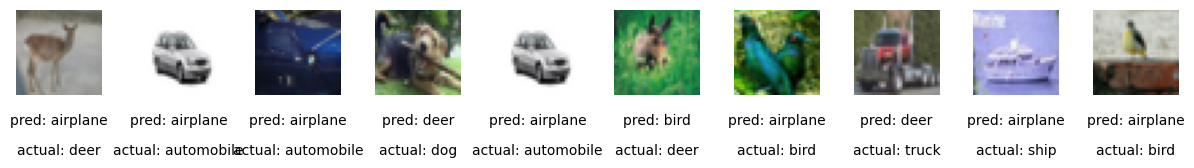

In [12]:
# Visualize some predictions
n_to_show = 10
indices = np.random.choice(range(len(x_test)), n_to_show)

fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i, idx in enumerate(indices):
    img = x_test[idx]
    ax = fig.add_subplot(1, n_to_show, i + 1)
    ax.axis('off')
    ax.text(0.5, -0.35, f'pred: {preds_single[idx]}', fontsize=10, ha='center', transform=ax.transAxes)
    ax.text(0.5, -0.7, f'actual: {actual_single[idx]}', fontsize=10, ha='center', transform=ax.transAxes)
    ax.imshow(img)

plt.show()

## Cleanup

In [13]:
# Finish W&B run
wandb.finish()
print("W&B run finished successfully.")

epoch/accuracy,▁▄▆▇▇██
epoch/epoch,▁▂▃▅▆▇█
epoch/learning_rate,████▃▃▁
epoch/loss,█▄▃▂▂▁▁
epoch/val_accuracy,▁▇█▆▅▅▆
epoch/val_loss,▁▁▂▃▅▇█
learning_rate,███▃▃▁▁
epoch/accuracy,0.3867
epoch/epoch,6
epoch/learning_rate,1e-05
epoch/loss,1.79444


W&B run finished successfully.


In [14]:
# ═══════════════════════════════════════════════════════════════════════════════
# CLEANUP: Restart kernel to fully release GPU memory
# ═══════════════════════════════════════════════════════════════════════════════
# TensorFlow/CUDA does not release GPU memory within a running Python process.
# Restarting the kernel is the only guaranteed way to free all GPU resources.
#
# NOTE: Only run this cell after all work is complete and saved.
#       The kernel restart will clear all variables and outputs.

# import IPython
# print("Restarting kernel to release GPU memory...")
# IPython.Application.instance().kernel.do_shutdown(restart=True)